# setup

In [1]:
import os
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from shapely import wkt
from shapely.geometry import Point, Polygon
from pyproj import Transformer
import pickle
import h3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# All these files are internal, so we could not upload them to github
waerme_gdf=gpd.read_file("waerme.geojson")
pv_gdf=gpd.read_file("pv.geojson")
nexiga=gpd.read_file("nexiga.geojson")

#### Cluster resolution, 11 is about the size of an average house
RES = 11

def add_h3(df):
    df = df.copy()
    df["h3"] = None
    valid = df["geometry"].notnull()
    df.loc[valid, "h3"] = df.loc[valid, "geometry"].apply(lambda g: h3.latlng_to_cell(g.y, g.x, RES))
    return df

waerme_gdf = add_h3(waerme_gdf)
pv_gdf = add_h3(pv_gdf)
nexiga = add_h3(nexiga)
demographic_cloumns = nexiga.columns

print("aggregating h3 cells")
# Heat pumps per hex
waerme_agg = waerme_gdf.groupby("h3").agg(heatpump_count=("geometry", "count"), avg_power=("Leistung", "mean"))
# PV systems per hex
pv_agg = pv_gdf.groupby("h3").agg(pv_count=("geometry", "count"), avg_peak=("kWp", "mean"))
# Demographic values per hex
nexiga_agg = nexiga.groupby("h3").agg(income_category=("kk_kat", "median"), pro_ev_attitude=("lceemob", "mean"))

# merge all nexiga data on the h3 column
merged = nexiga_agg.join(waerme_agg, how="left").join(pv_agg, how="left").fillna(0)
merged = merged.reset_index()
waerme_gdf.reset_index()
nexiga.reset_index()

nexiga_waerme_join_h3 = nexiga.join(waerme_gdf, lsuffix="_waerme", how="left")
all_data_joined_on_h3 = nexiga.join(waerme_gdf, lsuffix="_waerme", how="left").join(pv_gdf, lsuffix="_pv", how="left")
waerme_grouped_income = nexiga_waerme_join_h3.groupby("kk_kat").agg(heatpump_count=("geometry", "count"))
waerme_grouped_income.reset_index()

merged["geometry"] = merged["h3"].apply(lambda h: Polygon(h3.cell_to_boundary(h)))

pv_gdf = gpd.GeoDataFrame(merged, geometry="geometry", crs="EPSG:4326")
pv_gdf.to_file("h3.geojson", driver="GeoJSON")

kk_kat_totals = nexiga["kk_kat"].value_counts().sort_index()
waerme_grouped_income["kk_kat_total"] = waerme_grouped_income.index.map(kk_kat_totals)
waerme_grouped_income["rate_per_kk_kat"] = (
    waerme_grouped_income["heatpump_count"] / waerme_grouped_income["kk_kat_total"]
)

ERROR 1: PROJ: proj_create_from_database: Open of /home/nils/miniconda3/envs/hackathon/share/proj failed
Skipping field Unnamed: 5: unsupported OGR type: 10


aggregating h3 cells


In [3]:
df = all_data_joined_on_h3.copy()
display(df)
for a in df.columns.tolist():
    print(a)
print(len(set(df["h3"])))

,_uid_,id_waerme,v_lfd,v_dat_adm,v_dat_post,kgs44,his,kgs36,kgs22,ags,...,Station oder Maschennetz,Umspannwerke (versorgend),HS/MS-Trafos (versorgend),Abgänge (versorgend),Umspannwerke (anstehend),HS/MS-Trafos (anstehend),Abgänge (anstehend),Info zur Ermittlung,geometry,h3
0,1.0,199251.0,58.0,2101001,2103060,083151097925201529706816710000078,15746487.0,08315109000007,08315109022501,08315109,...,None,None,None,None,None,None,None,:netzname_ambiguous,POINT (7.86628 48.03862),8b1f81c99180fff
1,2.0,29.0,58.0,2101001,2103060,0831507679395010981149429100024313,224226341.0,08315076000243,08315076005302,08315076,...,None,None,None,None,None,None,None,:netzname_ambiguous,POINT (7.86943 48.04292),8b1f81c9912dfff
2,3.0,60.0,58.0,2101001,2103060,0831507679395010981068083100002134,20338030.0,08315076000021,08315076005303,08315076,...,None,None,None,None,None,None,None,:netzname_ambiguous,POINT (7.86964 48.04279),8b1f81c9912dfff
3,4.0,100.0,58.0,2101001,2103060,0831507679395010981068083100002136A,25660174.0,08315076000021,08315076005303,08315076,...,None,None,None,None,None,None,None,:netzname_ambiguous,POINT (7.86938 48.04296),8b1f81c998d3fff
4,5.0,102.0,58.0,2101001,2103060,0831507679395010981068095500013046,227046197.0,08315076000130,08315076005303,08315076,...,None,None,None,None,None,None,None,:netzname_ambiguous,POINT (7.86969 48.04315),8b1f81c998defff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75906,75907.0,45335.0,58.0,2101001,2103060,0831504879258006136067969600001233,6780703.0,08315048000012,08315048004901,08315048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
75907,75908.0,15855.0,62.0,2201001,2203060,0831507479379010683068055440008924,19961923.0,08315074400089,08315074005103,08315074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
75908,75909.0,48610.0,58.0,2101001,2103060,083150157920600199106786620000277,2880957.0,08315015000027,08315015020402,08315015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
75909,75910.0,13568.0,62.0,2201001,2203060,083150747937901068306806134003655,21531575.0,08315074400365,08315074005112,08315074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


_uid_
id_waerme
v_lfd
v_dat_adm
v_dat_post
kgs44
his
kgs36
kgs22
ags
kgs22_name
kgs8_name
plz
mplz
po_name
pot_name
str_name
hnr
hnr_zs
hnr_kompl
hnr_typ
lcew
lchh
kk_mio
kk_kat
dskz
kk_idx
lcgchar
lcbjkl
lcschicht
lcalter
lckumw
lckpre
lckneu
lcewb
lcewewa
lceemob
nx_x_etrsu
nx_y_etrsu
nx_kenn
geometry_waerme
h3_waerme
id
Typ
Eigentum_pv
Unnamed: 3
Einbaudatum_pv
Gemeinde_pv
Straßenname
Hausnummer_pv
Kundenkennzeichen
Kundenname
Leistung
Status_pv
Zähleranlage
Zähleranlage Datum
Heizstab vorhanden?
Heizstab Leistung
BP Position
ÜP Position
NS-HA-Fremdverteilung
NS-HA-Kasten
Station
NS-Sonderverbraucher
key
Position_pv
geometry_pv
h3_pv
Datenbestand
Tabelle
ID
Gemeinde
Straße
Hausnummer
Gewinnung
Betriebsspannung [kV]
vereinbarte Anschlusswirkleistung [kW]
kWp
Einbaudatum
Eigentum
Status
Bemerkung
Position
NS Strecke
Station oder Maschennetz
Umspannwerke (versorgend)
HS/MS-Trafos (versorgend)
Abgänge (versorgend)
Umspannwerke (anstehend)
HS/MS-Trafos (anstehend)
Abgänge (anstehend)
Inf

In [4]:
#demographic_cloumns =     #Hier nach Baujahr des Hauses und evtl. andere relevante Parameter angeben

demographic_columns = [a for a in demographic_cloumns if a not in [
    "geometry", "_uid_", "his", "kgs22_name", "kgs8_name", "h3", "plz", "mplz"
    ] + 
"""V_LFD
V_DAT_POST
KGS44
HIS
KGS36
KGS22
KGS22_NAME
KGS8_NAME
PLZ
MPLZ
PO_NAME
POT_NAME
STR_NAME
HNR
HNR_ZS
HNR_KOMPL
HNR_TYP
HNR_TYP""".lower().split("\n")
    ]
print(demographic_columns)
print(df[demographic_columns])

['id', 'v_dat_adm', 'ags', 'lcew', 'lchh', 'kk_mio', 'kk_kat', 'dskz', 'kk_idx', 'lcgchar', 'lcbjkl', 'lcschicht', 'lcalter', 'lckumw', 'lckpre', 'lckneu', 'lcewb', 'lcewewa', 'lceemob', 'nx_x_etrsu', 'nx_y_etrsu', 'nx_kenn']
                id v_dat_adm       ags  lcew  lchh    kk_mio  kk_kat  dskz  \
0       67000644.0   2101001  08315109   4.0   2.0  2.284643     7.0   0.0   
1       71638843.0   2101001  08315076   2.0   1.0  1.026705     6.0   0.0   
2      108777038.0   2101001  08315076   0.0   0.0  6.346322     6.0   0.0   
3      107339344.0   2101001  08315076   2.0   1.0  6.346322     6.0   0.0   
4       56805443.0   2101001  08315076   0.0   0.0  4.177462     6.0   0.0   
...            ...       ...       ...   ...   ...       ...     ...   ...   
75906          NaN   2101001  08315048   7.0   3.0  3.049309     4.0   0.0   
75907          NaN   2201001  08315074  59.0  37.0  7.429903     5.0   0.0   
75908          NaN   2101001  08315015   3.0   1.0  1.054182     4.0   0

In [5]:
df = all_data_joined_on_h3.copy()
df["Einbaujahr"] = df["Einbaudatum"].apply(lambda x : x.year)
df = df.dropna(subset=["h3", "Einbaujahr"])
df_counts = df[[
    "h3", 
    "Einbaujahr",    
    ] + demographic_columns].groupby(by=["h3", "Einbaujahr"]).count()["v_dat_adm"].reset_index().rename(columns={"v_dat_adm":"N_PVs"})
df_means = df[[
    "h3", 
    "Einbaujahr",    
    ] + [a for a in demographic_columns if a != "v_dat_adm" and a in df.select_dtypes(include=np.number).columns.tolist()]].groupby(by=["h3", "Einbaujahr"]).mean().reset_index()

print(len(set(df["h3"])) * len(set(df["Einbaujahr"])))


outlist = [ (i, j)
    for i in set(df.h3)
    for j in set(df.Einbaujahr)]
newdf = pd.DataFrame(data=outlist, columns=['h3','Einbaujahr'])
df_cross = pd.merge(newdf, df_counts, how = "left", on= ["h3", "Einbaujahr"]).fillna(0)
df_cross = pd.merge(df_cross, df_means, how = "left", on= ["h3", "Einbaujahr"])

display(df_cross)

468200


,h3,Einbaujahr,N_PVs,id,lcew,lchh,kk_mio,kk_kat,dskz,kk_idx,...,lcalter,lckumw,lckpre,lckneu,lcewb,lcewewa,lceemob,nx_x_etrsu,nx_y_etrsu,nx_kenn
0,8b1f81536359fff,1925.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8b1f81536359fff,1960.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8b1f81536359fff,1969.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8b1f81536359fff,1970.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8b1f81536359fff,1972.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468195,8b1f802c016cfff,2020.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468196,8b1f802c016cfff,2021.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468197,8b1f802c016cfff,2022.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468198,8b1f802c016cfff,2023.0,1.0,54274642.0,6.0,3.0,3.656263,6.0,0.0,105.433115,...,4.0,2.0,8.0,6.0,28000.0,42.0,5.0,402384.067,5310221.607,6.0


In [ ]:
from sklearn.model_selection import train_test_split
# Load data.
print(df_cross)
df_cross["PV_present"] = df_cross.apply(lambda row : sum(df_cross[(df_cross["h3"]==row["h3"])&(df_cross["Einbaujahr"] <row["Einbaujahr"])]["N_PVs"]), axis=1)

dft = df_cross.set_index(["h3", "Einbaujahr"], drop=False)
dft = dft.drop(columns=["id", "h3"])
print(dft)
dftr = dft[dft["Einbaujahr"]<2020]
dfte = dft[dft["Einbaujahr"]>=2020]
#train_x,test_x, train_y, test_y= train_test_split(dft.drop(columns=["N_PVs"]), dft["N_PVs"], test_size=0.33, random_state=42)
train_y,test_y = dftr["N_PVs"], dfte["N_PVs"]
train_x, test_x= dftr.drop(columns=["N_PVs"]), dfte.drop(columns=["N_PVs"])
#print(train_x)


                     h3  Einbaujahr  N_PVs          id  lcew  lchh    kk_mio  \
0       8b1f81536359fff      1925.0    0.0         NaN   NaN   NaN       NaN   
1       8b1f81536359fff      1960.0    0.0         NaN   NaN   NaN       NaN   
2       8b1f81536359fff      1969.0    0.0         NaN   NaN   NaN       NaN   
3       8b1f81536359fff      1970.0    0.0         NaN   NaN   NaN       NaN   
4       8b1f81536359fff      1972.0    0.0         NaN   NaN   NaN       NaN   
...                 ...         ...    ...         ...   ...   ...       ...   
468195  8b1f802c016cfff      2020.0    0.0         NaN   NaN   NaN       NaN   
468196  8b1f802c016cfff      2021.0    0.0         NaN   NaN   NaN       NaN   
468197  8b1f802c016cfff      2022.0    0.0         NaN   NaN   NaN       NaN   
468198  8b1f802c016cfff      2023.0    1.0  54274642.0   6.0   3.0  3.656263   
468199  8b1f802c016cfff      2024.0    0.0         NaN   NaN   NaN       NaN   

        kk_kat  dskz      kk_idx  ...  

1990 nan
1991 nan
1992 0.9997926742089617
1993 0.9997926742089617
1994 0.998909676233612
1995 0.9998142153770501
1996 0.9994054107826732
1997 0.9995853642217977
1998 0.9981725844480851
1999 0.9983418371601505
2000 0.9828434771565743
2001 0.9853020125194575
2002 0.9878270187549221
2003 0.9865424942573133
2004 0.9738311125949842
2005 0.9641487693322115
2006 0.9595860159527005
2007 0.9605951345169776
2008 0.9552540146604855
2009 0.9385049352135499
2010 0.929611739250649
2011 0.9203617895152574
2012 0.953484109190348
2013 0.9615851163426902
2014 0.971628851974873
2015 0.9749873237619346
2016 0.9741585682961159
2017 0.9781573304114674
2018 0.9634780807695872
2019 0.9424276920878687
ungesehen:
2020 0.9320316820093101
2021 0.924239409299623
2022 0.9136812931109349
2024 0.8523408584599355


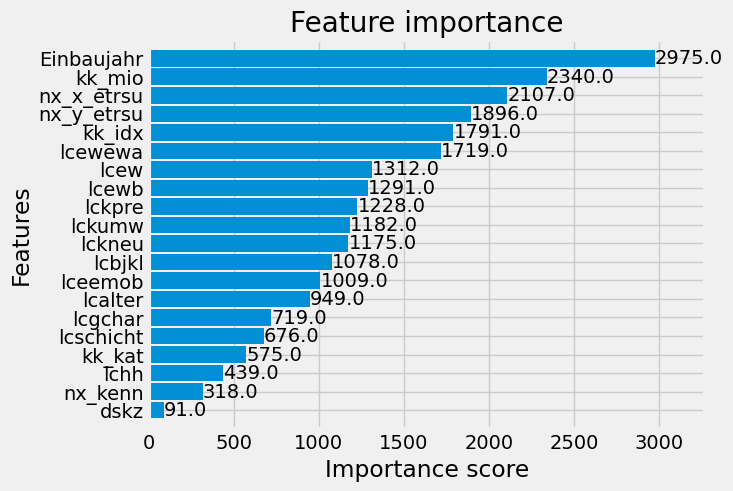

In [111]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

reg = xgb.XGBRegressor(n_estimators=1000)
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#x_trainScaled = scaler.fit_transform(train_x)

reg.fit(train_x, train_y)
        #eval_set=[(train_x, train_y), (test_x, test_y)],
        #early_stopping_rounds=50,
       #verbose=False)
_ = plot_importance(reg, height=0.9)

pred_y = reg.predict(test_x)
tpred_y = reg.predict(train_x)

mse = mean_squared_error(y_true=test_y,
                   y_pred=pred_y)
from sklearn.metrics import f1_score

for y in range(1990, 2020):
        f1 = f1_score(train_y[train_x["Einbaujahr"]==y].reset_index()["N_PVs"].tolist(), tpred_y[train_x["Einbaujahr"]==y].astype(int), average="weighted")
        print(y, f1)
print("ungesehen:")

for y in [2020, 2021, 2022, 2024]:
        f1 = f1_score(test_y[test_x["Einbaujahr"]==y].reset_index()["N_PVs"].tolist(), pred_y[test_x["Einbaujahr"]==y].astype(int), average="weighted")
        print(y, f1)


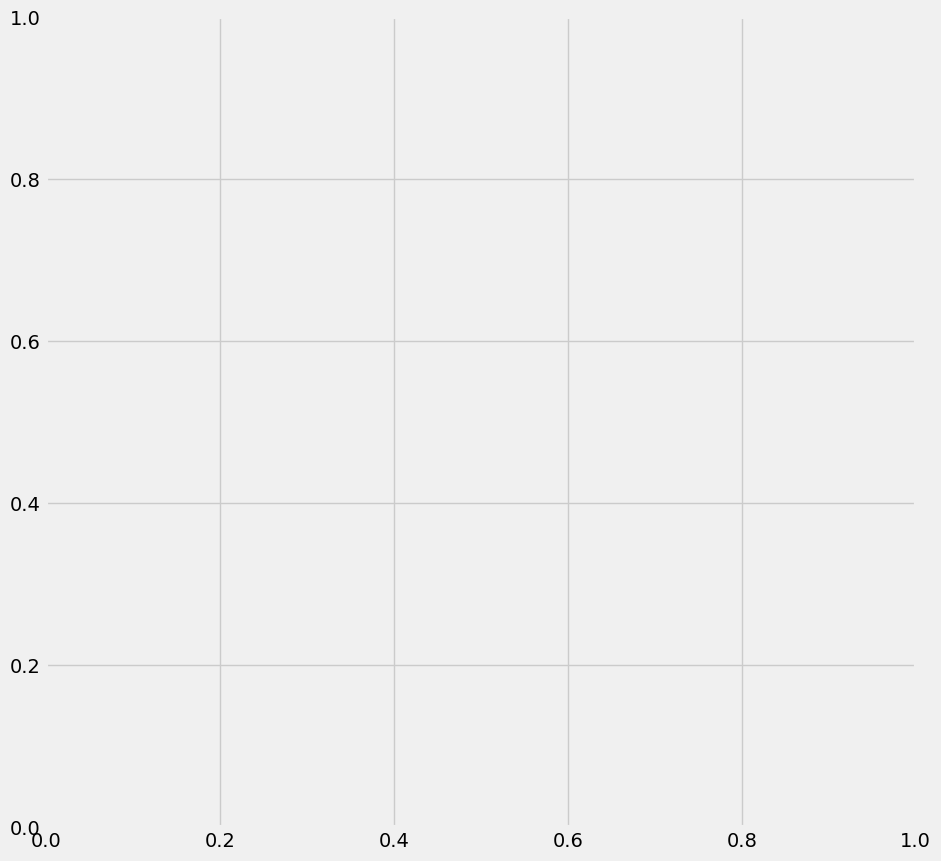

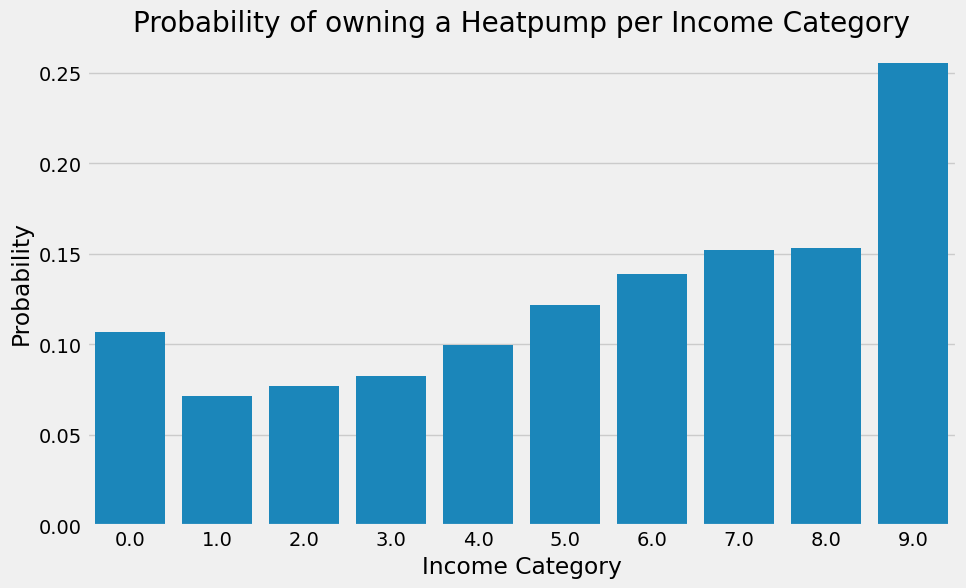

ValueError: Could not interpret value `pv_count` for `y`. An entry with this name does not appear in `data`.

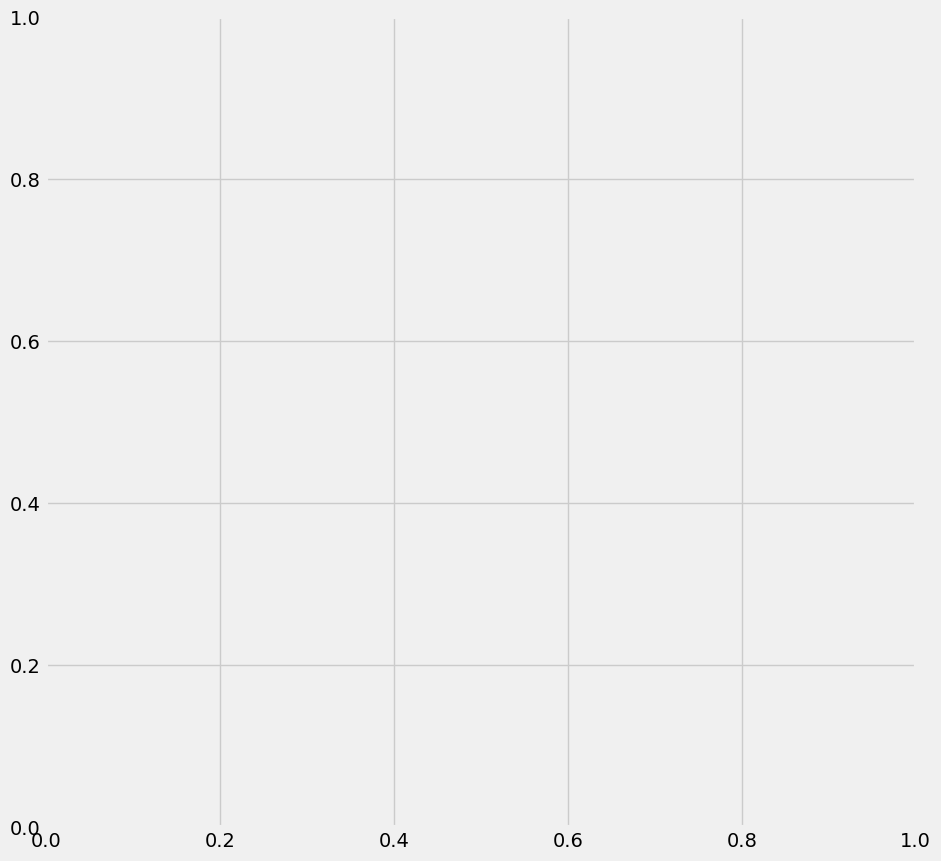

<Figure size 1000x600 with 0 Axes>

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.figure(figsize=(10, 6)) # Create a new figure for clarity
sns.barplot(data=waerme_grouped_income, x="kk_kat", y="rate_per_kk_kat")
plt.title('Probability of owning a Heatpump per Income Category')
plt.xlabel('Income Category')
plt.ylabel('Probability')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.figure(figsize=(10, 6)) # Create a new figure for clarity
sns.barplot(data=waerme_grouped_income, x="kk_kat", y="pv_count")
plt.title('PV installations per Income Category')
plt.xlabel('Income Category')
plt.ylabel('Number of PV installs')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.figure(figsize=(10, 6)) # Create a new figure for clarity
sns.barplot(data=waerme_grouped_income, x="kk_kat", y="heatpump_count")
plt.title('Heat pumps per Income Category')
plt.xlabel('Income Category')
plt.ylabel('Number of Heat pumps')
plt.show()

plt.figure(figsize=(10, 6)) # Create a new figure for clarity
sns.barplot(data=all_data_joined_on_h3.groupby("kk_kat").agg(pv_count=("geometry", "count")).reset_index(), x="kk_kat", y="pv_count")
plt.title('pv per Income Category')
plt.xlabel('Income Category')
plt.ylabel('Number of pv')
plt.show()